In [1]:
import pyphi
import math
import numpy as np
import itertools
from tqdm import tqdm
import utils
import math
import sys
from pyphi.exceptions import StateUnreachableError

pyphi.config.PROGRESS_BARS = False
pyphi.config.PARALLEL = False


Welcome to PyPhi!

If you use PyPhi in your research, please cite the paper:

  Mayner WGP, Marshall W, Albantakis L, Findlay G, Marchman R, Tononi G.
  (2018). PyPhi: A toolbox for integrated information theory.
  PLOS Computational Biology 14(7): e1006343.
  https://doi.org/10.1371/journal.pcbi.1006343

Documentation is available online (or with the built-in `help()` function):
  https://pyphi.readthedocs.io

To report issues, please use the issue tracker on the GitHub repository:
  https://github.com/wmayner/pyphi

For general discussion, you are welcome to join the pyphi-users group:
  https://groups.google.com/forum/#!forum/pyphi-users

To suppress this message, either:
  - Set `WELCOME_OFF: true` in your `pyphi_config.yml` file, or
  - Set the environment variable PYPHI_WELCOME_OFF to any value in your shell:
        export PYPHI_WELCOME_OFF='yes'



# Plotting settings

In [2]:
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import cycler
plt.rcParams['axes.prop_cycle'] = cycler.cycler('color', plt.cm.tab20b.colors[2::4])
plt.style.use('presentation.mplstyle')

# min and max system size to consider
N_min = 2
N_max = 5
N_step = 1
n_mc_runs = 10 # number of random tpm generations for random construction results

# Functions for calculating the bounds

In [3]:
def generate_subsystem_High_selectivity(n_nodes, order):
    """
    Generates the transition probability matrix (TPM) and the subsystem object
    for the high selectivity reflexive susbsystem
    the subsystem has selectivity of 1 and maximum integrated information
    for mechanism size of K over itself
    """
    all_states = list(pyphi.utils.all_states(n_nodes))
    state = (0,) * n_nodes
    node_marginalizers = utils.node_marginalizers(n_nodes, all_states)
    sbn_marg = np.array(
        [
            utils.order_k_marginalizer(order, n, node_marginalizers)
            for n in range(n_nodes)
        ]
    ).T

    network = pyphi.Network(1 - sbn_marg)
    subsystem = pyphi.Subsystem(network, state)
    return subsystem

def selectivity_1_candidate_MIPs(order, n_nodes):
    """
    Generates the candidate partitions
    for the high selectivity reflexive susbsystem
    subsystem has selectivity of 1 and maximum phi for mechanism size of K over itself
    It generates only  K/2 + 1 partitons (proof in the paper)
    """
    if order == n_nodes:
        yield pyphi.models.cuts.KPartition(
            pyphi.models.cuts.Part(mechanism=tuple(range(order)), purview=()),
            pyphi.models.cuts.Part(mechanism=(), purview=tuple(range(order))),
        )
    else:
        for k in range(1, order // 2 + 1):
            part1 = tuple(range(k))
            part2 = tuple(range(k, order))
            part1 = pyphi.models.cuts.Part(mechanism=part1, purview=part1)
            part2 = pyphi.models.cuts.Part(mechanism=part2, purview=part2)
            partition = pyphi.models.cuts.KPartition(part1, part2)
            yield partition
        yield pyphi.models.cuts.KPartition(
            pyphi.models.cuts.Part(
                mechanism=tuple(range(1, order)), purview=tuple(range(order))
            ),
            pyphi.models.cuts.Part(mechanism=(0,), purview=()),
        )


def inside_outside_symetric_subsets(system, mechanism):
    """generates all the subsets of a system
    while all the nodes inside of a mechanism are treated the same
    and all the nodes outside of the mechanism are treated the same
    """
    outside = tuple(set(system).difference(set(mechanism)))
    for n_inside in range(len(mechanism) + 1):
        for n_outside in range(len(outside) + 1):
            purview = mechanism[:n_inside] + outside[:n_outside]
            if len(purview) > 0:
                yield purview

from pyphi.partition import all_partitions, partition_types
@partition_types.register("SYM")
def sym_partitions(mechanism, purview, node_labels=None):
    '''
    Generate partions under assumptions of summetry as defined for Figure 2
    Reduces the computations by removing redundant partitions
    '''
    partitions = set()
    for partition in all_partitions(mechanism, purview, node_labels):
        partition_signature = str()
        for part in partition.parts:
            for purview_node in part.purview:
                if purview_node in part.mechanism:
                    partition_signature += chr(len(part.mechanism) + 97)
                else:
                    partition_signature += chr(len(part.mechanism) + 65)
        if partition_signature in partitions:
            continue
        else:
            partitions.add(partition_signature)
            yield partition


In [4]:
def High_Selectivity_phi_k(subsystem, K, just_effect=True):
    """
    Calcuates the phi of a mechanism of size K
    for the high selectivity reflexive susbsystem
    subsystem has selectivity of 1 and maximum phi for some K' \neq K
    It uses a subset of candidate purviews due to symmetry
    """
    N = len(subsystem)
    mechanism = tuple(np.arange(N)[:K])
    candidate_purviews = inside_outside_symetric_subsets(tuple(np.arange(N)), mechanism)
    assert pyphi.config.PARTITION_TYPE == "SYM"

    effect = subsystem.mie(mechanism=mechanism, purviews=candidate_purviews)
    phi_e = effect.phi

    if not just_effect:
        candidate_purviews = inside_outside_symetric_subsets(
            tuple(np.arange(N)), mechanism
        )
        cause = subsystem.mic(mechanism=mechanism, purviews=candidate_purviews)
        phi_c = cause.phi
        phi = min(phi_e, phi_c)
    else:
        phi_c = None
        phi = None
    return phi_e, phi_c, phi

def High_Selectivity_Sum_phi(subsystem, just_effect=False):
    N = len(subsystem)

    sum_phi_e = 0
    sum_phi_c = 0
    sum_phi = 0

    if just_effect:
        sum_phi_c = None
        sum_phi = None

    for order in range(1, N + 1):
        phi_e, phi_c, phi = High_Selectivity_phi_k(subsystem, order, just_effect=True)
        sum_phi_e += math.comb(N, order) * phi_e
        if not just_effect:
            sum_phi_c += math.comb(N, order) * phi_c
            sum_phi += math.comb(N, order) * phi

    return sum_phi_e, sum_phi_c, sum_phi


def High_Selectivity_Sum_UB(N):
    """
    Calculates the upperbound for sum of effect integrated information
    for high selectivity regime (pi(M|M) = 1  for all M |M|=k)
    N (int) : System size
    """
    sum_bound = N + N ** 2
    for K in tqdm(range(2, N)):
        subsystem = generate_subsystem_High_selectivity(N, K)
        phi_e = High_Selectivity_phi_star_k(subsystem, K, just_effect=True)[0]
        sum_bound += math.comb(N, K) * phi_e
    return sum_bound


# @ray.remote
def High_Selectivity_phi_star_k(subsystem, K, just_effect=True):
    """
    Calcuates the phi of a mechanism of size K
    for the high selectivity reflexive susbsystem
    subsystem has selectivity of 1 and maximum phi for mechanism size of K over itself
    It uses only the K/2 + 1 partitons (proof in the paper)
    """
    N = len(subsystem)
    mechanism = tuple(np.arange(N)[:K])
    effect = subsystem.find_mip(
        direction=pyphi.direction.Direction.EFFECT,
        mechanism=mechanism,
        purview=mechanism,
        partitions=list(selectivity_1_candidate_MIPs(K, N)),
    )
    phi_e = effect.phi
    if not just_effect:
        candidate_purviews = inside_outside_symetric_subsets(
            tuple(np.arange(N)), mechanism
        )
        cause = subsystem.mic(mechanism=mechanism, purviews=candidate_purviews)
        phi_c = cause.phi
        purview_c = cause.purview
        phi = min(phi_e, phi_c)
    else:
        phi_c = None
        phi = None
    return phi_e, phi_c, phi

# Figure 1 - Phi(k)

100%|██████████| 3/3 [00:00<00:00, 10.91it/s]


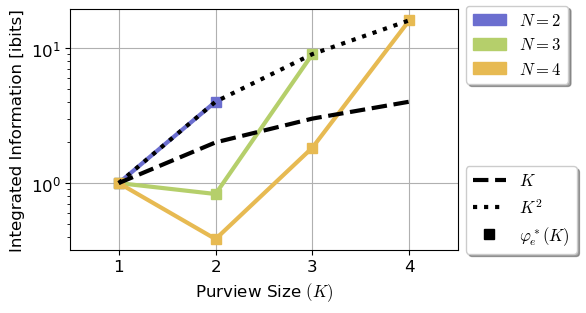

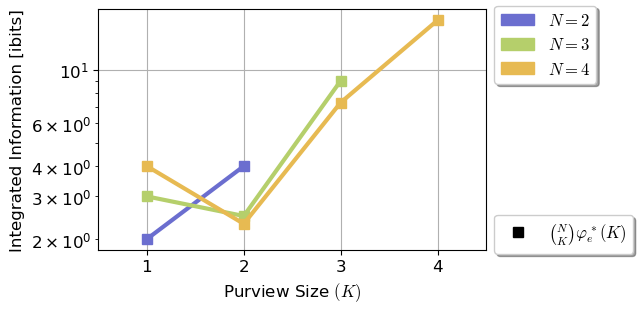

In [5]:
plt.style.use("presentation.mplstyle")
marker_cycler = itertools.cycle(("o", "v", "s", "p", "^", "s", ">", "8"))
legend_elements_n = []
pyphi.config.PARALLEL = True
for n_nodes in tqdm(range(N_min, N_max, N_step)):
    orders = np.arange(1, n_nodes + 1)
    phis = []
    for i, order in enumerate(orders):
        subsystem = generate_subsystem_High_selectivity(n_nodes, order)
        phis += [High_Selectivity_phi_star_k(subsystem, K=order, just_effect=True)]
    phis_e = np.array([p[0] for p in phis])
    phis_c = np.array([p[1] for p in phis])
    phis = np.array([p[2] for p in phis])
    
    marker = next(marker_cycler)
    plt.figure(1)
    color = next(plt.gca()._get_lines.prop_cycler)["color"]
    legend_elements_n += [
        Patch(facecolor=color, edgecolor=color, label=r"$N={0}$".format(n_nodes))
    ]
    label = r"$\varphi_e(K)$, $N={0}$".format(n_nodes)
    plt.plot(orders, phis_e, color=color, marker="s", linestyle="-", label=label)

    plt.figure(2)
    color = next(plt.gca()._get_lines.prop_cycler)["color"]
    mechanism_count = [math.comb(n_nodes, b) for b in range(1, n_nodes + 1)]
    plt.plot(
        orders,
        mechanism_count * phis_e,
        linestyle="-",
        color=color,
        marker="s",
        label=label,
    )


plt.figure(1)
legend_elements = []
label = r"$K$"
legend_elements += [Line2D([0], [0], color="k", linestyle="--", label=label)]

label = r"$K^2$"
legend_elements += [Line2D([0], [0], color="k", linestyle=":", label=label)]

label = r"$\varphi^*_e(K)$"
legend_elements += [Line2D([0], [0], color="k", marker="s", linestyle="", label=label)]

plt.plot(orders, orders, "k--", label=r"$K$")
plt.plot(orders, orders ** 2, "k:", label=r"$K^2$")
plt.yscale("log")
plt.ylabel("Integrated Information [ibits]")
plt.xlabel(r"Purview Size $(K)$")
plt.xlim(orders.min() - 0.5, orders.max() + 0.5)
legend1 = plt.legend(
    handles=legend_elements_n, loc="upper left", shadow=True, bbox_to_anchor=(1, 1.05)
)
plt.legend(
    handles=legend_elements, loc="lower left", shadow=True, bbox_to_anchor=(1, -0.05)
)
plt.gca().add_artist(legend1)


plt.figure(2)
legend_elements = []

label = r"$\binom{N}{K}\varphi^*_e(K)$"
legend_elements += [Line2D([0], [0], color="k", marker="s", linestyle="", label=label)]

plt.yscale("log")
plt.ylabel("Integrated Information [ibits]")
plt.xlabel(r"Purview Size $(K)$")
plt.xlim(orders.min() - 0.5, orders.max() + 0.5)
legend1 = plt.legend(
    handles=legend_elements_n, loc="upper left", shadow=True, bbox_to_anchor=(1, 1.05)
)
plt.legend(
    handles=legend_elements, loc="lower left", shadow=True, bbox_to_anchor=(1, -0.05)
)
plt.gca().add_artist(legend1)

# Figure 2 - sum phi vs k_star

In [6]:
sys.setrecursionlimit(60000)
pyphi.config.PARALLEL = True
pyphi.config.PROGRESS_BARS= True

pyphi.config.PARALLEL_PURVIEW_EVALUATION['parallel'] = False
pyphi.config.PARALLEL_PURVIEW_EVALUATION['sequential_threshold'] = 1
pyphi.config.PARALLEL_PURVIEW_EVALUATION['chunksize'] = 1
pyphi.config.PARALLEL_PURVIEW_EVALUATION['progress'] = False

pyphi.config.PARALLEL_MECHANISM_PARTITION_EVALUATION['parallel'] = True
pyphi.config.PARALLEL_MECHANISM_PARTITION_EVALUATION['sequential_threshold'] = 2**10
pyphi.config.PARALLEL_MECHANISM_PARTITION_EVALUATION['chunksize'] = 2**8
pyphi.config.PARALLEL_MECHANISM_PARTITION_EVALUATION['progress'] = False


pyphi.config.PARTITION_TYPE = "SYM"
pyphi.config.WELCOME_OFF = True

2024-01-25 22:00:34,518	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
0it [00:00, ?it/s]
100%|██████████| 2/2 [00:00<00:00, 122.75it/s]


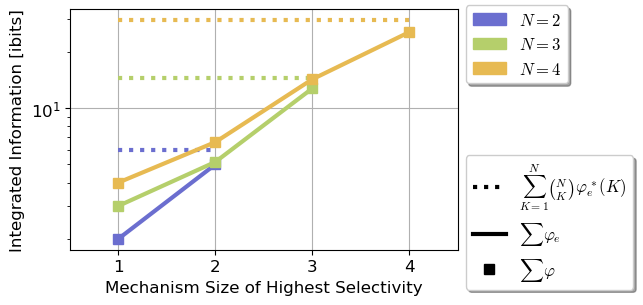

In [7]:
marker_cycler = itertools.cycle(("o", "v", "s", "p", "^", "s", ">", "8"))
legend_elements_n = []
sum_phi_vs_Kstar_N = {}
for n_nodes in range(N_min, N_max, N_step):
    orders = np.arange(1, n_nodes + 1)

    sum_phis = []
    for i, order in enumerate(orders):
        subsystem = generate_subsystem_High_selectivity(n_nodes, order)
        sum_phis += [High_Selectivity_Sum_phi(subsystem, just_effect=True)]

    sum_phis_e = np.array([p[0] for p in sum_phis])
    sum_phis_c = np.array([p[1] for p in sum_phis])
    sum_phis = np.array([p[2] for p in sum_phis])
    
    sum_bound = High_Selectivity_Sum_UB(n_nodes)

    marker = next(marker_cycler)
    color = next(plt.gca()._get_lines.prop_cycler)["color"]

    label = (
        r"$\sum_{K = 1}^N \binom{N}{K} \min \{ K, \varphi^*_e(K) \}$"
        + r", $N={0}$".format(n_nodes)
    )
    plt.plot(
        orders,
        sum_bound * np.ones(len(orders)),
        linestyle=":",
        color=color,
        label=label,
    )
    plt.plot(orders, sum_phis_e, marker="s", linestyle="-", color=color, label=label)
    legend_elements_n += [
        Patch(facecolor=color, edgecolor=color, label=r"$N={0}$".format(n_nodes))
    ]
    sum_phi_vs_Kstar_N[n_nodes] = sum_phis_e


legend_elements = []
label = r"$\sum_{K = 1}^N \binom{N}{K}\varphi^*_e(K)$"
legend_elements += [Line2D([0], [0], color="k", linestyle=":", label=label)]

label = r"$\sum \varphi_e$"
legend_elements += [Line2D([0], [0], color="k", linestyle="-", label=label)]

label = r"$\sum \varphi$"
legend_elements += [Line2D([0], [0], color="k", marker="s", linestyle="", label=label)]

plt.yscale("log")
plt.ylabel("Integrated Information [ibits]")
plt.xlabel(r"Mechanism Size of Highest Selectivity")
plt.xlim(orders.min() - 0.5, orders.max() + 0.5)
legend1 = plt.legend(
    handles=legend_elements_n, loc="upper left", shadow=True, bbox_to_anchor=(1, 1.05)
)
plt.legend(
    handles=legend_elements, loc="lower left", shadow=True, bbox_to_anchor=(1, -0.2)
)
plt.gca().add_artist(legend1)

# sum phi(K_star)
Sum over phi_k where k is the mechanism size with selectivity 1. This can be calculated fast and can act as a numerical upperbound.

In [8]:
system_size = np.arange(N_min, N_max, N_step).astype(int)
sum_bounds = np.zeros(len(system_size))
for i, N in enumerate(system_size):
    N = int(N)
    sum_bounds[i] = High_Selectivity_Sum_UB(N)  / 2**N
print(sum_bounds)

0it [00:00, ?it/s]
100%|██████████| 2/2 [00:00<00:00, 112.17it/s]

[1.5        1.81127812 1.85200256]


# Fig 3 - Sum phi for random constructions

In [9]:
import ray
ray.init(num_cpus=15, ignore_reinit_error=True)
sys.setrecursionlimit(60000)
pyphi.config.PARALLEL = False
pyphi.config.PROGRESS_BARS= True

pyphi.config.PARALLEL_CONCEPT_EVALUATION['parallel'] = False
pyphi.config.PARALLEL_CONCEPT_EVALUATION['sequential_threshold'] = 32
pyphi.config.PARALLEL_CONCEPT_EVALUATION['chunksize'] = 32
pyphi.config.PARALLEL_CONCEPT_EVALUATION['progress'] = True

pyphi.config.PARALLEL_PURVIEW_EVALUATION['parallel'] = False
pyphi.config.PARALLEL_PURVIEW_EVALUATION['sequential_threshold'] = 32
pyphi.config.PARALLEL_PURVIEW_EVALUATION['chunksize'] = 32
pyphi.config.PARALLEL_PURVIEW_EVALUATION['progress'] = False

pyphi.config.PARALLEL_MECHANISM_PARTITION_EVALUATION['parallel'] = False
pyphi.config.PARALLEL_MECHANISM_PARTITION_EVALUATION['sequential_threshold'] = 2**10
pyphi.config.PARALLEL_MECHANISM_PARTITION_EVALUATION['chunksize'] = 2**10
pyphi.config.PARALLEL_MECHANISM_PARTITION_EVALUATION['progress'] = False

pyphi.config.PARTITION_TYPE = "ALL"
pyphi.config.RELATION_COMPUTATION = 'ANALYTICAL'
pyphi.config.WELCOME_OFF = True

2024-01-25 22:00:48,469	INFO worker.py:1558 -- Calling ray.init() again after it has already been called.


In [10]:
@ray.remote
def calc_random_construction(n_nodes, const_type, verbose=True):
    """
    Generate state_by_node TPM using cosnt_type
    for a system of n_nodes and calculate \varphi
    """
    pyphi.config.WELCOME_OFF = True
    pyphi.config.PARTITION_TYPE = "ALL"
    if const_type == "random":
        sbn_marg = np.random.rand(2 ** n_nodes, n_nodes)
    elif const_type == "random deterministic":
        sbn_marg = np.random.rand(2 ** n_nodes, n_nodes)
        threshold = np.random.rand()
        sbn_marg = (sbn_marg > threshold).astype(float)
    else:
        raise Exception("Invalid construction type")

    network = pyphi.Network(sbn_marg)
    all_states = pyphi.utils.all_states(n_nodes)

    # finding first reachable state
    for state in all_states:
        try:
            subsystem = pyphi.Subsystem(network, state)
        except StateUnreachableError:
            continue
        break

    ces = pyphi.compute.ces(subsystem)
    sum_causes = sum([d.cause.phi for d in ces])
    sum_effects = sum([d.effect.phi for d in ces])
    sum_overall_phi = sum([d.phi for d in ces])

    system_state = pyphi.new_big_phi.system_intrinsic_information(subsystem)
    ces = ces.resolve_congruence(system_state)
    sum_relations_phi = pyphi.relations.relations(ces).sum_phi()

    if verbose:
        print("sum overall phi: ", sum_overall_phi, "sum effects phi: ", sum_effects)

    return sum_effects, sum_causes, sum_overall_phi, sum_relations_phi


sum_phi_random = {}
for n_nodes in range(N_min, N_max, N_step):
    print(n_nodes)
    for construction in ['random deterministic', 'random']:

        sum_effects = np.zeros(n_mc_runs)
        sum_causes = np.zeros(n_mc_runs)
        sum_overall_phi = np.zeros(n_mc_runs)
        sum_relations_phi = np.zeros(n_mc_runs)

        workers = []
        for i in range(n_mc_runs):
            workers += [
                calc_random_construction.remote(n_nodes, construction, verbose=False)
            ]

        for i in range(n_mc_runs):
            (
                sum_effects[i],
                sum_causes[i],
                sum_overall_phi[i],
                sum_relations_phi[i],
            ) = ray.get(workers[i])

        print("Construction: ", construction, ", max sum phi: ", sum_overall_phi.max())
        sum_phi_random[construction, n_nodes] = (sum_overall_phi, sum_relations_phi)

2
Construction:  random deterministic , max sum phi:  1.5
Construction:  random , max sum phi:  1.0830224366638936
3
Construction:  random deterministic , max sum phi:  3.6590217074462767
Construction:  random , max sum phi:  1.648598715287151
4
(raylet) WARNING: 16 PYTHON worker processes have been started on node: 9a87b7d9e2b543700ede25e94e6ab366eac7d7c9aaa6d05fde831e55 with address: 127.0.0.1. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
Construction:  random deterministic , max sum phi:  6.662348504340802
Construction:  random , max sum phi:  2.502249991032924


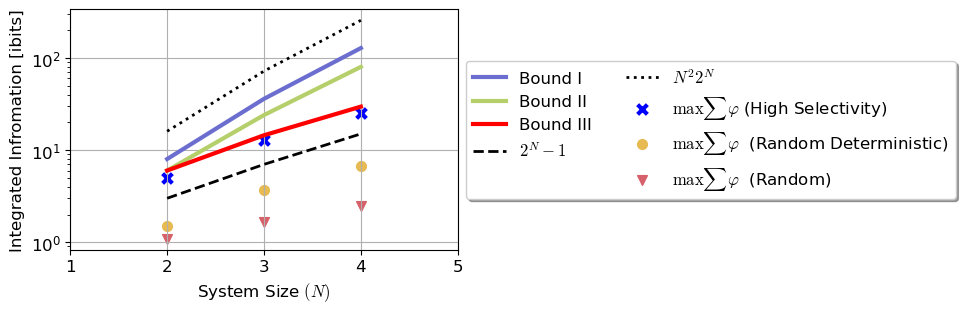

In [11]:
system_size = np.arange(N_min, N_max, N_step)
################################
label = "Bound I"
color = next(plt.gca()._get_lines.prop_cycler)["color"]
plt.plot(
    system_size,
    0.5 * system_size ** 2 * 2 ** system_size,
    color=color,
    label=label,
)


################################
label = "Bound II"
color = next(plt.gca()._get_lines.prop_cycler)["color"]
plt.plot(
    system_size,
    0.25 * system_size * (system_size + 1) * (2 ** system_size),
    color=color,
    label=label,
)


################################
label = "Bound III"
plt.plot(
    system_size, sum_bounds * 2.0 ** system_size, color="r", label=label
)


################################
label = r"$ 2^N - 1$"
plt.plot(system_size, 2 ** system_size - 1, "k--", linewidth=2, label=label)

label = r"$ N^2 2^{N}$"
plt.plot(
    system_size,
    system_size ** 2.0 * 2.0 ** system_size,
    "k:",
    linewidth=2,
    label=label,
)


################################
################################
max_sum_phi = []
max_sum_phi_e = []
for n in system_size:
    max_sum_phi_e += [sum_phi_vs_Kstar_N[n].max()]

label = r"$\max \sum \varphi$" + " (High Selectivity)"
plt.scatter(system_size, max_sum_phi_e, color="b", marker="x", label=label)


################################
################################
max_sum_phi_random_det = []
max_sum_phi_e_random_det = []
for n in system_size:
    max_sum_phi_random_det += [sum_phi_random[("random deterministic", n)][0].max()]


color = next(plt.gca()._get_lines.prop_cycler)["color"]
label = r"$\max \sum \varphi$" + "  (Random Deterministic)"
plt.scatter(system_size, max_sum_phi_random_det, marker="o", color=color, label=label)


################################
################################
max_sum_phi_random = []
max_sum_phi_e_random = []
for n in system_size:
    max_sum_phi_random += [sum_phi_random[("random", n)][0].max()]


color = next(plt.gca()._get_lines.prop_cycler)["color"]
label = r"$\max \sum \varphi$" + "  (Random)"
plt.scatter(system_size, max_sum_phi_random, marker="v", color=color, label=label)

################################
################################
plt.xscale("linear")
plt.yscale("log")
plt.ylabel("Integrated Infromation [ibits]")
plt.xlabel(r"System Size $(N)$")
plt.xlim(N_min-1, N_max)
plt.legend(loc="center left", shadow=True, bbox_to_anchor=(1, 0.5), ncol=2)

# Fig 4 - Relations

In [12]:
def sum_of_minimum_among_subsets(values):
    """Return the sum of the minimum of all subsets with size >1 of the values."""
    counts = 2 ** (np.arange(len(values), 0, -1).astype(np.longdouble) - 1) - 1
    return np.sum(np.sort(values) * counts)

In [13]:
sys.setrecursionlimit(60000)
pyphi.config.PARALLEL = False
pyphi.config.PROGRESS_BARS= False

pyphi.config.RELATION_COMPUTATION = 'ANALYTICAL'
pyphi.config.WELCOME_OFF = True

[16.0, 429.0, 139384.0]
[8.0, 69.0, 1592.0]


0it [00:00, ?it/s]
100%|██████████| 2/2 [00:00<00:00, 99.45it/s]


[14.0, 183.20748725985497235, 26146.334694583213388]


100%|██████████| 4/4 [00:00<00:00,  4.49it/s]

[6.5, 49.499999999999997877, 4905.625]


/var/folders/r0/90d2gc2j1553kwrwl3fnl01m0000gn/T/ipykernel_51543/3696362136.py:155: RuntimeWarning: divide by zero encountered in log10
  functions=(lambda x: np.log10(np.log10(x)), lambda x: 10.0 ** (10.0 ** x)),
/var/folders/r0/90d2gc2j1553kwrwl3fnl01m0000gn/T/ipykernel_51543/3696362136.py:155: RuntimeWarning: invalid value encountered in log10
  functions=(lambda x: np.log10(np.log10(x)), lambda x: 10.0 ** (10.0 ** x)),


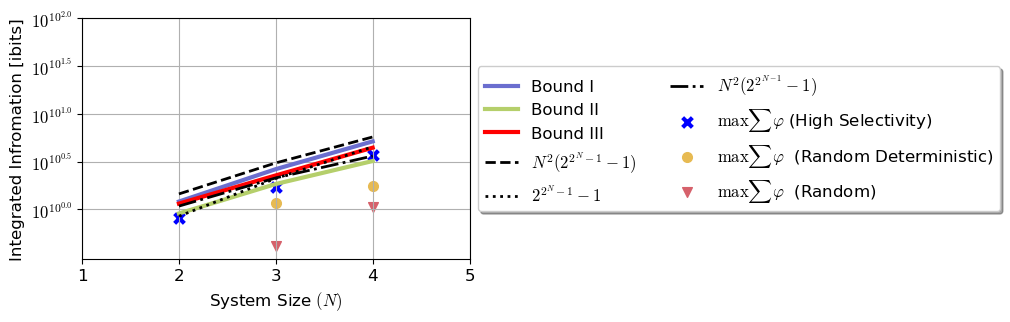

(raylet) [2024-01-26 19:42:48,132 E 51562 728610] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-01-25_22-00-29_413441_51543 is over 95% full, available space: 5260935168; capacity: 121123069952. Object creation will fail if spilling is required.
(raylet) [2024-01-26 19:43:00,470 E 51562 728610] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-01-25_22-00-29_413441_51543 is over 95% full, available space: 5249548288; capacity: 121123069952. Object creation will fail if spilling is required.
(raylet) [2024-01-26 19:43:10,522 E 51562 728610] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-01-25_22-00-29_413441_51543 is over 95% full, available space: 5217243136; capacity: 121123069952. Object creation will fail if spilling is required.


In [14]:
#### all mechanism have N as purview and KN as phi
max_sum_phi_r = []
for N in system_size:
    sum_phi = np.ulonglong(0.0)
    # Sum of phi excluding self-relations
    phi_purview_ratio = [
        len(mech) for mech in pyphi.utils.powerset(range(N), nonempty=True)
    ]
    sum_phi = N * sum_of_minimum_among_subsets(phi_purview_ratio)
    # Count self-relations
    sum_phi += sum(
        [len(mech) * N for mech in pyphi.utils.powerset(range(N), nonempty=True)]
    )
    max_sum_phi_r += [sum_phi]
print(max_sum_phi_r)
label = "Bound I"
color = next(plt.gca()._get_lines.prop_cycler)["color"]
plt.plot(system_size, max_sum_phi_r, color=color, label=label)

#### all mechanism have themselves as purview and k^2 as phi
# system_size = np.arange(2, 7)
max_sum_phi_r = []
for N in system_size:
    sum_phi = 0.0
    phi_purview_ratio = [
        len(mech) + 1 for mech in pyphi.utils.powerset(range(N - 1), nonempty=False)
    ]
    sum_phi = N * sum_of_minimum_among_subsets(phi_purview_ratio)
    # Count self-relations
    sum_phi += sum(
        [len(mech) ** 2 for mech in pyphi.utils.powerset(range(N), nonempty=True)]
    )
    max_sum_phi_r += [sum_phi]
print(max_sum_phi_r)
label = "Bound II"
color = next(plt.gca()._get_lines.prop_cycler)["color"]
plt.plot(system_size, max_sum_phi_r, color=color, label=label)

#### all mechanism have themselves as purview and phi^* (high selectivity) as phi
pyphi.config.PARTITION_TYPE = "SYM"
max_sum_phi_r = []
for N in system_size:
    phi_k = {}
    phi_k[1] = 1
    phi_k[N] = N ** 2
    for K in tqdm(range(2, N)):
        subsystem = generate_subsystem_High_selectivity(N, K)
        phi_k[K] = High_Selectivity_phi_star_k(subsystem, K, just_effect=True)[0]
    sum_phi = 0.0
    # for _ in range(N):
    # phi_purview_ratio = [phi_k[len(mech)+1]/(len(mech)+1) for mech in pyphi.utils.powerset(range(N-1), nonempty=False)]
    phi_purview_ratio = [
        phi_k[len(mech)] / len(mech)
        for mech in pyphi.utils.powerset(range(N), nonempty=True)
    ]
    # print(phi_purview_ratio)
    sum_phi = N * sum_of_minimum_among_subsets(phi_purview_ratio)
    # Count self-relations
    sum_phi += sum(
        [phi_k[len(mech)] for mech in pyphi.utils.powerset(range(N), nonempty=True)]
    )
    max_sum_phi_r += [sum_phi]
print(max_sum_phi_r)
label = "Bound III"
plt.plot(system_size, max_sum_phi_r, color="r", label=label)

####
label = r"$ N^2 (2^{2^N - 1}-1)$"
plt.plot(
    system_size,
    system_size ** 2 * (2.0 ** (2.0 ** system_size - 1) - 1),
    "k--",
    linewidth=2,
    label=label,
)
# print(2.**(2.**system_size - 1) - 1)
label = r"$ 2^{2^{N} -1}-1$"
plt.plot(
    system_size,
    (2.0 ** (2.0 ** (system_size) - 1) - 1),
    "k:",
    linewidth=2,
    label=label,
)
# print(2.**(2.**(system_size-1) - 1) - 1)
label = r"$ N^2 (2^{2^{N-1}}-1)$"
plt.plot(
    system_size,
    system_size ** 2 * (2.0 ** (2.0 ** (system_size - 1)) - 1),
    "k-.",
    linewidth=2,
    label=label,
)
# print(2.**(2.**(system_size-1) - 1) - 1)

### system having selectivity of 1 and maximum phi for N over N
max_sum_phi_r = []
for N in range(N_min, N_max, N_step):
    orders = [N]
    sum_phis_r = []
    cess = []

    subsystem = generate_subsystem_High_selectivity(N, N)
    phi_k = {}
    for K in tqdm(range(1, N + 1)):
        phi_k[K] = High_Selectivity_phi_k(subsystem, K, just_effect=True)[0]
    sum_phis_r = 0.0
    phi_purview_ratio = [
        phi_k[len(mech)] / N
        for mech in pyphi.utils.powerset(range(N), nonempty=True)
    ]
    sum_phis_r = N * sum_of_minimum_among_subsets(phi_purview_ratio)
    # Count self-relations
    sum_phis_r += sum(
        [
            len(mech) * phi_k[len(mech)] / N
            for mech in pyphi.utils.powerset(range(N), nonempty=True)
        ]
    )
    max_sum_phi_r += [sum_phis_r]
print(max_sum_phi_r)
label = r"$\max \sum \varphi$" + " (High Selectivity)"
plt.scatter(system_size, max_sum_phi_r, color="b", marker="x", label=label)

#### Random Deterministic
max_sum_phi_random_det = []
for n in range(N_min, N_max, N_step):
    max_sum_phi_random_det += [sum_phi_random[("random deterministic", n)][1].max()]


color = next(plt.gca()._get_lines.prop_cycler)["color"]
label = r"$\max \sum \varphi$" + "  (Random Deterministic)"
plt.scatter(system_size, max_sum_phi_random_det, marker="o", color=color, label=label)

#### Random
max_sum_phi_random = []
for n in range(N_min, N_max, N_step):
    max_sum_phi_random +=  [sum_phi_random[("random", n)][1].max()]


color = next(plt.gca()._get_lines.prop_cycler)["color"]
label = r"$\max \sum \varphi$" + "  (Random)"
plt.scatter(system_size, max_sum_phi_random, marker="v", color=color, label=label)

# # Add empty dummy legend items
# plt.plot(np.zeros(1), np.zeros([1, 1]), color="w", alpha=0, label=" ")


plt.xscale("linear")
plt.xlim(N_min-1, N_max)
plt.ylim(2, 10.0 ** 100)

plt.yscale(
    "function",
    functions=(lambda x: np.log10(np.log10(x)), lambda x: 10.0 ** (10.0 ** x)),
)
y_axis_exponent = np.array([0, 0.5, 1.0, 1.5, 2.0]).astype(np.longdouble)
plt.yticks(
    10.0 ** 10.0 ** y_axis_exponent,
    [r"$10^{10^{" + str(e)[:3] + "}}$" for e in y_axis_exponent],
)

plt.ylabel("Integrated Infromation [ibits]")
plt.xlabel(r"System Size $(N)$")
plt.legend(loc="center left", shadow=True, bbox_to_anchor=(1, 0.5), ncol=2)